# Tools for calculating reconnection rate and reconnected flux

In [1]:
import numpy as np
import sdf_helper as sh
import pandas as pd
import os as os
import matplotlib.pyplot as plt

### Flux and Reconnection Rate Calculator Functions

In [2]:
def recon_flux_half(data):
    """calculated reconnected flux on half domain"""
    By = data.Magnetic_Field_By
    nx, ny = data.Grid_Grid_mid.dims
    xb = data.Grid_Grid.data[0]
    flux = 0
    max_flux = 0
    for i in range(0,nx):
        flux = flux + (xb[i+1]-xb[i])*By.data[i,0] # h*By at y=0
        if (flux > max_flux):
            max_flux = flux
    return max_flux

    
def recon_flux(data):
    """Calculated reconnected flux on whole domain"""
    By = data.Magnetic_Field_By
    
    nx, ny = data.Grid_Grid_mid.dims
    xb = data.Grid_Grid.data[0]
    flux = 0
    max_flux = 0
    j = ny // 2
    for i in range(0, nx):
         # Iterate over positive half of y-coordinates
        flux += By.data[i, j] * (xb[i + 1] - xb[i])  # h*By at y coordinate
        if flux > max_flux:
            max_flux = flux
    return max_flux
    
def find_max_flux(fluxes):
    """Find the maximum flux in the fluxes array."""
    return max(fluxes)

def calculate_time_difference(times, fluxes, percent):
    """Calculate the time difference between flux=0.01 and percent% of max flux."""
    max_flux = find_max_flux(fluxes)
    target_flux = percent * max_flux + 0.01

    # Find index for flux > 0.01
    index_start = next(i for i, flux in enumerate(fluxes) if flux > 0.01)

    # Find index for flux > 25% of max flux
    index_target = next(i for i, flux in enumerate(fluxes) if flux > target_flux)

    # Calculate time difference
    time_difference = times[index_target] - times[index_start]
    return time_difference

def calculator(times, fluxes, percent):
    """Calculates dynamic measure of reconnection rate"""

    max_flux = find_max_flux(fluxes)
    target_flux = percent * max_flux + 0.01
    
    # Calculate change in flux 
    flux_change = percent * max_flux
    # Find index for flux > 0.01
    index_start = next(i for i, flux in enumerate(fluxes) if flux > 0.01)

    # Find index for flux > 25% of max flux
    index_target = next(i for i, flux in enumerate(fluxes) if flux > target_flux)

    # Calculate time difference
    time_difference = times[index_target] - times[index_start]
    
    #Calculate reconnection rate
    reco_rate = flux_change / time_difference
    
    
    return time_difference, reco_rate

def calculator_original(times, fluxes):
    """ Calculates Static measure of reconnection rate """

    target_flux = 0.05
    starting_flux = 0.01
    flux_change = target_flux-starting_flux
    # Find index for flux > 0.01
    index_start = next(i for i, flux in enumerate(fluxes) if flux > 0.01)

    # Find index for flux > 25% of max flux
    index_target = next(i for i, flux in enumerate(fluxes) if flux > target_flux)

    # Calculate time difference
    time_difference = times[index_target] - times[index_start]

    #Calculate reconnection rate
    reco_rate = flux_change / time_difference

    
    return time_difference, reco_rate

    

## Reconnected Flux Calculator

In [13]:
folder = '/local_raid/honproj2/conan/sim_5_hall_5'
data_dir = folder + '/Data'

In [14]:
data = sh.getdata(0,data_dir,verbose=False) 
N = 500

#Create times and fluxes
times = np.zeros(N)
fluxes = np.zeros(N)

for ind in range(0,N):
    data = sh.getdata(ind,data_dir,verbose=False)
    times[ind] = data.Last_dump_time_requested.data
    fluxes[ind] = recon_flux(data)
    


#Extract Lundquist Number from control.f90 file
src = folder + '/src/control.f90'
with open(src, 'r') as fp:
    # read all lines in a list
    lines = fp.readlines()
    line = lines[111] #this is where the eta_background is 
    
    # extract Lundquist number
    rl = [letter for letter in line if letter!=' ']
    number_list = rl[15:-5]
    s = ''.join(map(str, number_list))
    inv_lundquist_number = float(s)
    lundquist_number = 1/inv_lundquist_number 
      


In [15]:
# see if all available flux is reconnected
print(max(fluxes))

0.15584424984191858


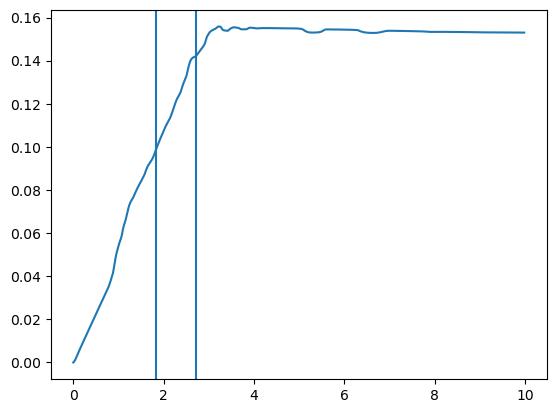

In [16]:
# Visualise the reconnected flux vs time
plt.plot(times, fluxes)
plt.axvline(1.84)
plt.axvline(2.72)

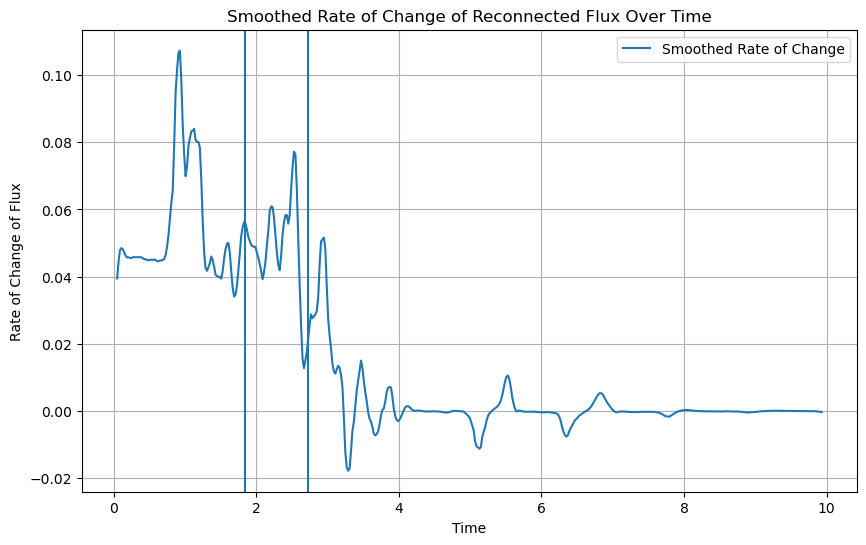

In [17]:
# Calculate the rate of change of the flux
flux_rate_of_change = np.diff(fluxes) / np.diff(times)

# Calculate the midpoints of each time interval for plotting
time_midpoints = (times[:-1] + times[1:]) / 2

# Smooth the rate of change using a simple moving average
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

# Choose a window size
window_size = 5  # Adjust based on your data for smoother results

smoothed_flux_rate_of_change = moving_average(flux_rate_of_change, window_size)
smoothed_time_midpoints = moving_average(time_midpoints, window_size)

# Plotting

plt.figure(figsize=(10, 6))
plt.plot(smoothed_time_midpoints, smoothed_flux_rate_of_change, linestyle='-', label='Smoothed Rate of Change')
plt.title('Smoothed Rate of Change of Reconnected Flux Over Time')
plt.xlabel('Time')
plt.ylabel('Rate of Change of Flux')
plt.grid(True)
plt.axvline(1.84)
plt.axvline(2.72)
plt.legend()
plt.show()

## Dynamic Measure of $V_{\text{rec}}$

In [18]:
output = {'Lundquist Number': lundquist_number}

percentages = [0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50]


for percent in percentages:
    t_rec, v_rate = calculator(times, fluxes, percent)
    #print(type(t_rec))
    output[f"t_rec{percent}"] = t_rec
    output[f"v_rate{percent}"] = v_rate
    print(percent)


output_DF = pd.DataFrame.from_dict(output, orient='index')

output_DF

0.1
0.15
0.2
0.25
0.3
0.35
0.4
0.45
0.5


,0
Lundquist Number,10000.000000
t_rec0.1,0.340000
v_rate0.1,0.045837
t_rec0.15,0.520000
v_rate0.15,0.044955
t_rec0.2,0.640000
v_rate0.2,0.048701
t_rec0.25,0.720000
v_rate0.25,0.054113
t_rec0.3,0.820000


In [19]:
filepath = folder+'/rates_times_5_hall_5.csv'
output_DF.to_csv(filepath)

In [20]:
import pickle

data_to_pickle = {'times':times, 'fluxes':fluxes}

with open(f'{folder}_data.pkl', 'wb') as file:
    pickle.dump(data_to_pickle, file)
    

## Static Measure of $V_{\text{rec}}$

In [21]:
t_rec_original, v_rec_original = calculator_original(times, fluxes)
print(t_rec_original, v_rec_original)
output = {'Lundquist Number': lundquist_number, 't_rec_original':t_rec_original, 
          'v_rec_original': v_rec_original}

original_DF = pd.DataFrame.from_dict(output, orient='index')

filepath = folder+'/original_rates.csv'
original_DF.to_csv(filepath)

0.7200000000000005 0.05555555555555552
